In [37]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
from utils.config import cfg

from models import WBDNet
from step import train_wbd

import torch.utils.data as data
from torch.autograd import Variable
from torch.utils.data.dataloader import default_collate

import os
import sys
import json

random.seed(cfg.manualSeed)
np.random.seed(cfg.manualSeed)
torch.manual_seed(cfg.manualSeed)
torch.cuda.manual_seed(cfg.manualSeed)

torch.cuda.manual_seed(cfg.manualSeed)  
torch.cuda.manual_seed_all(cfg.manualSeed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

def worker_init_fn(worker_id):   
    np.random.seed(cfg.manualSeed + worker_id)

In [80]:
parser = argparse.ArgumentParser(description='Training the model for word boundary discovery')

parser.add_argument('--data_path', type=str, default= 'x:/staff-bulk/ewi/insy/MMC/xinsheng/data/coco/audio/',
                    help='directory of database')   
parser.add_argument('--save_root',type=str,default='outputs/l3_w4',
                    help='path for saving model and results')    
# parameters
parser.add_argument("--start_epoch",type=int,default=100,
                    help='resume the pertra')
parser.add_argument("--epoch", type=int, default=100,
                    help="max epoch")
parser.add_argument("--optim", type=str, default="adam",
                    help="training optimizer", choices=["sgd", "adam"])
parser.add_argument('--batch_size', default=64, type=int, 
                    help='mini-batch size')
parser.add_argument('--lr', type=float, default=0.001, 
                    help='initial learning rate')
parser.add_argument('--lr_decay', default=50, type=int, metavar='LRDECAY',
                    help='Divide the learning rate by 10 every lr_decay epochs')
parser.add_argument('--momentum', default=0.9, type=float, metavar='M',
                    help='momentum')
parser.add_argument('--weight-decay', '--wd', default=1e-4, type=float,
                    help='weight decay (default: 1e-4)')  
parser.add_argument('--bce-weight', '--bw', default=50, type=float,
                    help='weight to face the data unblance')  

# evaluation
parser.add_argument('--only-val',default=False,type=bool,
                    help='True for evaluation with pre-trained model')

parser.add_argument('--BK_train',default=1,type=int,
                    help='neighbor number of the ground-truth boundary that considered as the boundary during training ')
parser.add_argument('--BK',default=0,type=int,
                    help='predicted boundary is considered to be correct is it is whiin BK frames of the ground-truth boundary')


# mel parameter
parser.add_argument('--max-wav-value', default=32768.0, type=float,
                        help='Maximum audiowave value')
parser.add_argument('--sampling-rate', default=16000, type=int,
                    help='Sampling rate')
parser.add_argument('--filter-length', default=800, type=int,
                    help='Filter length')
parser.add_argument('--hop-length', default=200, type=int,
                    help='Hop (stride) length')
parser.add_argument('--win-length', default=800, type=int,
                    help='Window length')
parser.add_argument('--mel-fmin', default=0.0, type=float,
                    help='Minimum mel frequency')
parser.add_argument('--mel-fmax', default=8000.0, type=float,
                    help='Maximum mel frequency')
parser.add_argument('--n-mel-channels', default=80, type=int,
                    help='Number of bins in mel-spectrograms')


args = parser.parse_args(args=[])
# args = parser.parse_args()


In [97]:

def pad_collate(batch):
    max_input_len = float('-inf')  
    
    for elem in batch:
        mel, target, length,cap_ID = elem
        max_input_len = max_input_len if max_input_len > length else length       

    for i, elem in enumerate(batch):
        mel, target, length,cap_ID = elem
        input_length = mel.shape[1]
        input_dim = mel.shape[0]

        pad_mel = np.zeros((input_dim,max_input_len), dtype=np.float)
        pad_mel[:input_dim, :input_length] = mel       

        pad_target = np.zeros(max_input_len,dtype=np.float)
        mask = np.zeros(max_input_len,dtype=np.float)
        pad_target[:input_length] = target
        mask[:input_length] = 1.0
        pad_mel = pad_mel.transpose(1,0)
        batch[i] = (pad_mel, pad_target, mask, length,cap_ID)
        # print('feature.shape: ' + str(feature.shape))
        # print('trn.shape: ' + str(trn.shape))

    batch.sort(key=lambda x: x[-2], reverse=True)

    return default_collate(batch)


class WBD_Data(data.DataLoader):
    def __init__(self, data_path,args,split='train'):
        self.args = args
        self.split = split
        if split=='train':
            self.data_dir = os.path.join(data_path,'train2014')
        else:
            self.data_dir = os.path.join(data_path,'val2014')
        self.filenames = self.load_filelnames(self.data_dir)[:64]

    def load_filelnames(self,data_dir):
        if self.split == 'train':
            path = data_dir + '/filenames/' + 'Bruce_1.0_None.json'
        else:
            path = data_dir + '/filenames/' + 'Bruce_1.0_None_uniqueImgID.json'
        with open(path,'rb') as f:
            data = json.load(f)
        return data

    def load_json(self,path):
        with open(path,'rb') as f:
            data = json.load(f)
        return data

    def load_target(self,wav_duration,mel_len,timecode):
        target = np.zeros(mel_len)
        times = []
        for item in timecode:
            if 'WORD' in item:
                time = item[0]
                times.append(time)
        times = np.array(times)

        positions = times * mel_len / (wav_duration*1000)
        positions = np.around(positions).astype(np.int32)
        if self.split == 'train':
            if self.args.BK_train == 0:
                target[positions] = 1
            else:
                pad_positions = list(positions)
                
                for i in range(self.args.BK_train):
                    k = i+1
                    positions_right = positions[:-1] + k
                    positions_left = positions[1:] - k
                    pad_positions = pad_positions + list(positions_left) + list(positions_right)
                target[pad_positions] = 1
        else:
            if self.args.BK == 0:
                target[positions] = 1
            else:
                pad_positions = list(positions)
                for i in range(self.args.BK):
                    k = i+1
                    positions_right = positions[:-1] + k
                    positions_left = positions[1:] - k
                    pad_positions = pad_positions + list(positions_left) + list(positions_right)
                target[pad_positions] = 1
        return target

    def __getitem__(self,index):
        data_dict = self.filenames[index]
        wav_name = data_dict['wavFilename']
        mel_name = wav_name.replace('.wav','.npy')
        mel_path = self.data_dir + '/mel/' + mel_name 
        mel =  np.load(mel_path,allow_pickle=True)
        json_path = self.data_dir + '/json/' + wav_name.replace('.wav','.json')
        json_dict = self.load_json(json_path)

        wav_duration = json_dict['duration']
        mel_len = mel.shape[1]
        timecode = json_dict['timecode']
        cap_ID = json_dict['captionID']

        target = self.load_target(wav_duration,mel_len,timecode)
        
        return mel, target, mel_len, cap_ID


    def __len__(self):
        return len(self.filenames)

In [81]:
dataset_val = WBD_Data(args.data_path,args,'val')
val_loader = torch.utils.data.DataLoader(
        dataset_val, batch_size=cfg.WBDNet.batch_size,
        drop_last=False, shuffle=False,collate_fn=pad_collate,worker_init_fn=worker_init_fn) 

In [82]:
model = WBDNet.RNN(cfg.WBDNet.input_size, cfg.WBDNet.batch_size, cfg.WBDNet.hidden_size)

In [118]:
def get_predicted_boundary(predict,k):
    stride = 2*k+1
    if stride == 1:
        stride = 3
    pading = int((stride-1)/2)
    # pdb.set_trace()
    max_pool = nn.MaxPool1d(stride,1,padding=pading).cuda()
    ext_predict = predict.unsqueeze(1)
    max_predict = max_pool(ext_predict).squeeze()
    if max_predict.shape[-1]<ext_predict.shape[-1]:
        mid = torch.zeros(ext_predict.shape).squeeze()
        mid[:,:max_predict.shape[-1]] = max_predict
        max_predict = mid
    max_mask = ((predict.to('cpu') - max_predict.to('cpu')) >= 0).int()
    sub_mask = max_mask -1
    predict = predict.to('cpu').detach() 
    predict = predict * max_mask + sub_mask
    return predict

Transfer wav to mel

In [44]:
def evaluation(model,val_loader,args):
    model.eval()
    
    exp_dir = args.save_root 
    model.cuda()
    model.load_state_dict(torch.load("%s/models/WBDNet_%d.pth" % (exp_dir,args.start_epoch)))
    print('loaded parametres from epoch %d' % args.start_epoch)
    
    
    total_retrieved = 0.0
    total_gt = 0.0
    total = 0.0
    TP = 0.0
    

    for i, (audio,target,mask,length,cap_ID) in enumerate(val_loader):
        audio = audio.float().cuda()
        target = target.int()
        mask = mask.int()
        output = model(audio)
        # if i==0 :
        #     pdb.set_trace()
        predict = get_predicted_boundary(output, args.BK)
        predict_label = (predict > 0.5) * mask
        # pdb.set_trace()
        total_retrieved += predict_label.sum()
        total_gt += ((target.sum()) + args.batch_size * 2 * args.BK) / (args.BK*2 + 1)
       
        total += mask.sum()
        # pdb.set_trace()
        TP += ((predict_label == target) * target).sum()
    Recall = TP / total_gt
    P = TP / total_retrieved
    F1 = 2*Recall*P/(Recall + P)

    metrics={}
    metrics['recall'] = Recall
    metrics['precision'] = P
    metrics['F1'] = F1    
    info = "Recall {:.2%} | Precision {:.2%} | F1 {:.2%}\n".format(Recall,P,F1)
    print(info)

In [45]:
evaluation(model,val_loader,args)

loaded parametres from epoch 100
Recall 95.12% | Precision 83.77% | F1 89.09%



In [119]:
model.eval()
    
exp_dir = args.save_root 
model.cuda()
model.load_state_dict(torch.load("%s/models/WBDNet_%d.pth" % (exp_dir,args.start_epoch)))
print('loaded parametres from epoch %d' % args.start_epoch)


total_retrieved = 0.0
total_gt = 0.0
total = 0.0
TP = 0.0

results = []
for i, (audio,target,mask,length,cap_ID) in enumerate(val_loader):
    result = {}
    audio = audio.float().cuda()
    target = target.int()
    mask = mask.int()
    output = model(audio)
    # if i==0 :
    #     pdb.set_trace()
    predict = get_predicted_boundary(output, args.BK)
    predict_label = (predict > 0.5) * mask
    result['cap_id'] = cap_ID
    result['mel'] = audio.cpu()
    result['length'] = length
    result['predict'] = predict_label
    result['ground-truth'] = target
    results.append(result)
    

   

loaded parametres from epoch 100


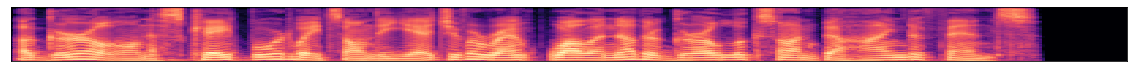

In [128]:
import librosa.display
length = results[0]['length'][0]
mel = results[0]['mel'][0].transpose(1,0).numpy()[:,:length]
length = results[0]['length'][0]
mel = mel[:,:length]
plt.figure(figsize=(20,1))
librosa.display.specshow(mel)
plt.show()

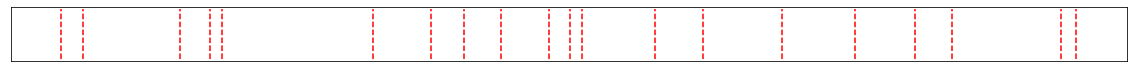

In [129]:
import matplotlib.pyplot as plt
from matplotlib import cm
position=np.where(target[0].numpy()==1)
plt.figure(figsize=(20,1))
plt.xticks(())#去掉坐标轴上的刻度
plt.yticks(())#去掉坐标轴上的刻度
plt.vlines(position,0, 2, colors = "r", linestyles = "dashed")
#plt.savefig(path)
plt.show()

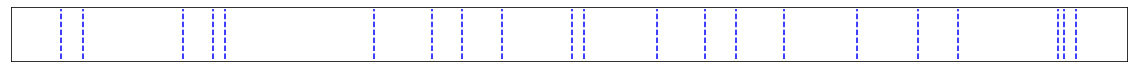

In [130]:
pre_position = np.where(predict_label[0].numpy()==1)
plt.figure(figsize=(20,1))
plt.xticks(())#去掉坐标轴上的刻度
plt.yticks(())#去掉坐标轴上的刻度
plt.vlines(pre_position,0, 2, colors = "b", linestyles = "dashed")
#plt.savefig(path)
plt.show()

In [125]:
cap_ID[0]

tensor(4935)

In [116]:
pre_position

(array([  0,   4,  27,  38,  63,  67,  75,  80,  81, 100, 115, 118, 119,
        140, 156, 157, 168, 169, 170, 212, 213, 214, 245, 246, 254, 255,
        279, 280, 300, 301, 316, 317, 318], dtype=int64),)